<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Aprendizaje%20Supervisado/Investor_Risk_Tolerance_and_Robo_Advisors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investor Risk Tolerance and Robo advisors**
El objetivo de este proyecto es construir un modelo de aprendizaje automático para predecir la tolerancia al riesgo o la aversión al riesgo de un inversor, y utilizar el modelo en un cuadro de mandos de un robo-asesor.

## **Content**

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
* [4.Evaluate Algorithms and Models](#4)        
    * [4.1. Train/Test Split](#4.1)
    * [4.2. Test Options and Evaluation Metrics](#4.2)
    * [4.3. Compare Models and Algorithms](#4.3)
* [5. Model Tuning and Grid Search](#5)  
* [6. Finalize the Model](#6)  
    * [6.1. Results on test dataset](#6.1)
    * [6.2. Feature Importance](#6.1)
    * [6.2. Feature Intuition](#6.3)

<a id='0'></a>
# 1. Problem Definition

En el marco de regresión supervisada utilizado para este estudio, la variable prevista es la "verdadera" tolerancia al riesgo de un individuo y las variables predictoras son atributos demográficos, financieros y de comportamiento de un individuo.

Para este estudio de caso, los datos utilizados proceden de la encuesta sobre las finanzas de los consumidores, realizada por el Consejo de la Reserva Federal. La fuente de datos es: https://www.federalreserve.gov/econres/scf_2009p.htm


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
# load dataset
dataset = pd.read_excel('SCFP2009panel.xlsx')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
type(dataset)

pandas.core.frame.DataFrame

In [ ]:
dataset.shape

(19285, 515)

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable

El conjunto de datos de la "Encuesta de Finanzas de los Consumidores" contiene los datos demográficos, el patrimonio neto y los activos financieros y no financieros de los hogares para los mismos datos demográficos en 2007 (antes de la crisis) y 2009 (después de la crisis).

En los siguientes pasos preparamos la variable predicha, que es la "verdadera" tolerancia al riesgo. Hay diferentes maneras de obtener la "verdadera" tolerancia al riesgo. La idea y el propósito de este estudio de caso es llegar a un enfoque para resolver el problema de las finanzas del comportamiento utilizando el aprendizaje automático.

Los pasos para calcular las variables predichas son los siguientes:

1) Calcular el activo de riesgo y los activos sin riesgo para todos los individuos de los datos de la encuesta. Los activos de riesgo y los activos sin riesgo se definen como sigue:

* **Activos con riesgo:** son las inversiones en fondos de inversión, acciones, bonos, materias primas y bienes inmuebles, y una estimación del capital humano.
* **Activos sin riesgo:** saldos de cuentas corrientes y de ahorro, certificados de depósito y otros saldos de efectivo y equivalentes.

2) Tomamos la relación entre los activos de riesgo y los activos totales de un inversor y la consideramos una medida de la tolerancia al riesgo de un inversor. A partir de los datos de SCF, tenemos los datos de los activos con y sin riesgo para los individuos para 2007 y 2009. Utilizamos estos datos y normalizamos los activos de riesgo con el precio de las acciones de 2007 frente al de 2009 para obtener la tolerancia al riesgo.
* **La tolerancia al riesgo** se define como la relación entre los activos de riesgo y los activos sin riesgo normalizados con la media del S&P500 de 2007 frente a la de 2009. Media del S&P500 en 2007: 1478 Media del S&P500 en 2009: 948.

3) En mucha literatura, un inversor inteligente es aquel que no cambia su tolerancia al riesgo durante el cambio del mercado. Por lo tanto, consideramos que los inversores que cambian su tolerancia al riesgo en menos de un 10% entre 2007 y 2009 son inversores inteligentes. Por supuesto, este es un juicio cualitativo y está sujeto a cambios. Sin embargo, como se ha mencionado anteriormente, más que ser exacto y preciso, el propósito de este estudio de caso es demostrar el uso del aprendizaje automático y proporcionar un marco basado en el aprendizaje automático en las finanzas del comportamiento y la gestión de carteras que puede aprovecharse para un análisis más detallado.


In [ ]:
# Media del SP500 durante 2007 y 2009
Average_SP500_2007=1478
Average_SP500_2009=948

# Tolerancia al riesgo 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

# Tolerancia al riesgo 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [ ]:
dataset2 = copy.deepcopy(dataset)  
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,FAMSTRUCT07,RACECL,H_RACECL,RACE,H_RACE,OCCAT107,OCCAT207,INDCAT07,HHEALTH07,SPHEALTH07,INCOME07,WAGEINC07,BUSSEFARMINC07,INTDIVINC07,KGINC07,SSRETINC07,TRANSFOTHINC07,PENACCTWD07,NORMINC07,RISK07,PSAVING07,WSAVED07,SAVED07,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,...,RESDBTPCT,OTHLOCPCT,CCBALPCT,INSTALLPCT,ODEBTPCT,TPAYPCT,MORTPAYPCT,CONSPAYPCT,REVPAYPCT,EQUITYPCT,DEQPCT,VOWNPCT,RETEQPCT,NORMINCPCT,CHECKINGPCT,MSAVINGPCT,CALLPCT,HOMEEQPCT,IRAKHPCT,PENEQPCT,VEHINSTPCT,EDNINSTPCT,OTHINSTPCT,HELOCPCT,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,5,2,2,3,3,1,3,1,3,3,56443.744181,56443.744181,0.0,0.0,0.0,0.0,0.0,0,69223.459844,3,5177.988243,1,0,0,0,0,0,0,0,1,...,0.0,0.0,-98.841249,3882.428459,0.0,-44.309806,-3.437401,-37.234311,-98.841249,6764000.0,1700000.0,-51.718701,5064000.0,-45.313644,168.22944,1400000.0,0.0,-54.412507,6000000.0,5064000.0,-11.224708,0.0,25000000.0,0.0,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,5,2,2,3,3,1,3,1,3,3,56443.744181,56443.744181,0.0,0.0,0.0,0.0,0.0,0,69223.459844,3,5177.988243,1,0,0,0,0,0,0,0,1,...,0.0,0.0,-98.841249,4094.744747,0.0,-44.309806,-3.437401,-37.234311,-98.841249,4569000.0,1800000.0,-51.718701,2769000.0,-45.313644,168.22944,1700000.0,0.0,-34.934215,6100000.0,2769000.0,3.109215,0.0,25000000.0,0.0,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,5,2,2,3,3,1,3,1,3,3,56443.744181,56443.744181,0.0,0.0,0.0,0.0,0.0,0,69223.459844,3,5177.988243,1,0,0,0,0,0,0,0,1,...,0.0,0.0,-98.841249,1802.283191,0.0,-44.309806,-3.437401,-37.234311,-98.841249,5540000.0,1200000.0,-17.232058,4340000.0,-45.313644,172.00732,1100000.0,0.0,-37.567285,6000000.0,4340000.0,-54.689858,0.0,25000000.0,0.0,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,5,2,2,3,3,1,3,1,3,3,56443.744181,56443.744181,0.0,0.0,0.0,0.0,0.0,0,69223.459844,3,5177.988243,1,0,0,0,0,0,0,0,1,...,0.0,0.0,-98.841249,1965.634921,0.0,-43.527015,-2.114626,-36.170486,-98.841249,3082500.0,1300000.0,-17.232058,1782500.0,-45.313644,172.00732,2300000.0,0.0,-34.519783,5900000.0,1782500.0,-46.085882,0.0,25000000.0,0.0,-33.333333,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,5,2,2,3,3,1,3,1,3,3,56443.744181,56443.744181,0.0,0.0,0.0,0.0,0.0,0,69223.459844,3,5177.988243,1,0,0,0,0,0,0,0,1,...,0.0,0.0,-98.885816,3969.876080,0.0,-44.733843,-3.437401,-36.170486,-98.885816,4128000.0,1200000.0,-13.783394,2928000.0,-45.313644,168.22944,1500000.0,0.0,-25.816716,6000000.0,2928000.0,12.392533,0.0,25000000.0,0.0,-38.596491,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


Calculemos la variación porcentual de la tolerancia al riesgo entre 2007 y 2009.

In [ ]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

* Comprobación de las filas con valores nulos o nan y eliminación de las mismas.

In [ ]:
# Comprobación de los valores nulos y eliminación de los mismos'''
print('Null Values =',dataset2.isnull().values.any())

Null Values = True


In [ ]:
# Eliminar las filas que contienen NA
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

# Comprobación de los valores nulos y eliminación de los mismos'''
print('Null Values =',dataset2.isnull().values.any())

Null Values = False


* Graficamos la tolerancia al riesgo de 2007 y 2009.

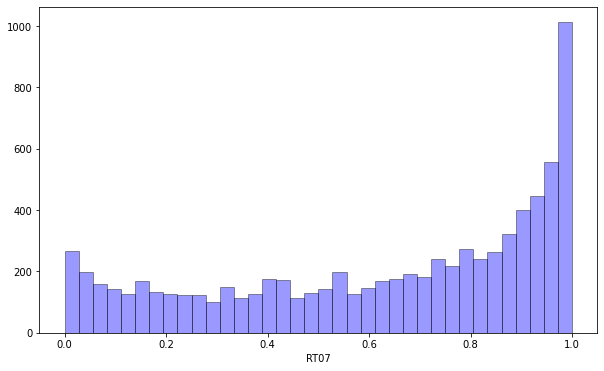

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(dataset2['RT07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

* Si observamos la tolerancia al riesgo de 2007, vemos que un número significativo de individuos tenía una tolerancia al riesgo cercana a uno, lo que significa que la inversión estaba más sesgada hacia los activos de riesgo en comparación con los activos sin riesgo. Ahora veamos la tolerancia al riesgo de 2009.

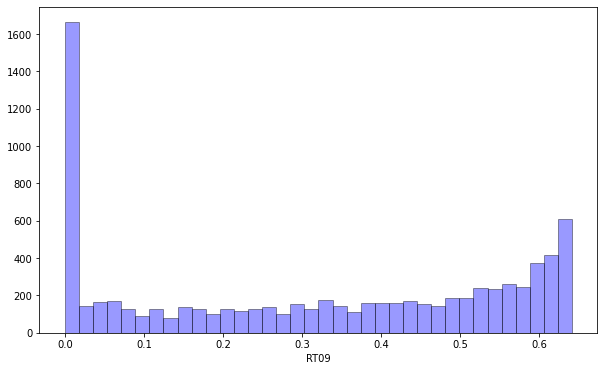

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(dataset2['RT09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [ ]:
dataset3 = copy.deepcopy(dataset2)  

* Claramente, el comportamiento de los individuos se invirtió en 2009 después de la crisis y la mayoría de la inversión fue en activos sin riesgo. La tolerancia al riesgo en general disminuyó, lo que se demuestra por el hecho de que la mayoría de la tolerancia al riesgo se acercó a 0 en 2009. En el siguiente paso elegimos a los inversores inteligentes cuya variación de la tolerancia al riesgo entre 2007 y 2009 fue inferior al 10%.


In [ ]:
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

* Asignamos la verdadera tolerancia al riesgo como la tolerancia al riesgo media de estos inversores inteligentes entre 2007 y 2009. Esta es la variable predicha para este estudio de caso. El objetivo sería predecir la verdadera tolerancia al riesgo de un individuo teniendo en cuenta las características demográficas, financieras y de disposición a asumir riesgos.

In [ ]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

* Dejemos de lado otras etiquetas que podrían no ser necesarias para la predicción.

In [ ]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

<a id='2.2.2'></a>
### 3.2.2.  Features elimination

*Para filtrar más las características hacemos lo siguiente:*

1.Comprobamos la descripción en el diccionario de datos (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt) y mantenemos sólo las características que sean intuitivas. La descripción es la siguiente:

**AGE:**  Hay 6 categorías de edad, donde 1 representa la edad inferior a 35 años y 6 la edad superior a 75 años.

**EDUC:** Hay 4 categorías de educación, donde 1 representa no tener estudios secundarios y 4 representa el grado universitario.

**MARRIED:** Representa el estado civil. Hay dos categorías donde 1 representa casado y 2 representa soltero.

**OCCU:** Representa la categoría de ocupación. El 1 representa la categoría de directivo y el 4 la de desempleado.

**KIDS:** Representa el número de hijos.

**NWCAT:** Representa la categoría de patrimonio neto. Hay 5 categorías, en las que 1 representa el patrimonio neto inferior al 25 por ciento y 5 el patrimonio neto superior al 90 por ciento.

**INCCL:** Representa la categoría de ingresos. Hay 5 categorías, en las que 1 es la de ingresos inferiores a 10.000 y 5 la de patrimonio neto superior a 100.000.

**RISK:** Representa la disposición a asumir riesgos en una escala de 1 a 4, donde 1 representa el mayor nivel de disposición a asumir riesgos.

1.Mantenemos sólo los factores intuitivos de 2007 y eliminamos todas las características intermedias y las relacionadas con 2009, ya que las variables de 2007 son las únicas necesarias para predecir la tolerancia al riesgo.

In [ ]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance']

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

* Veamos la correlación entre las características.

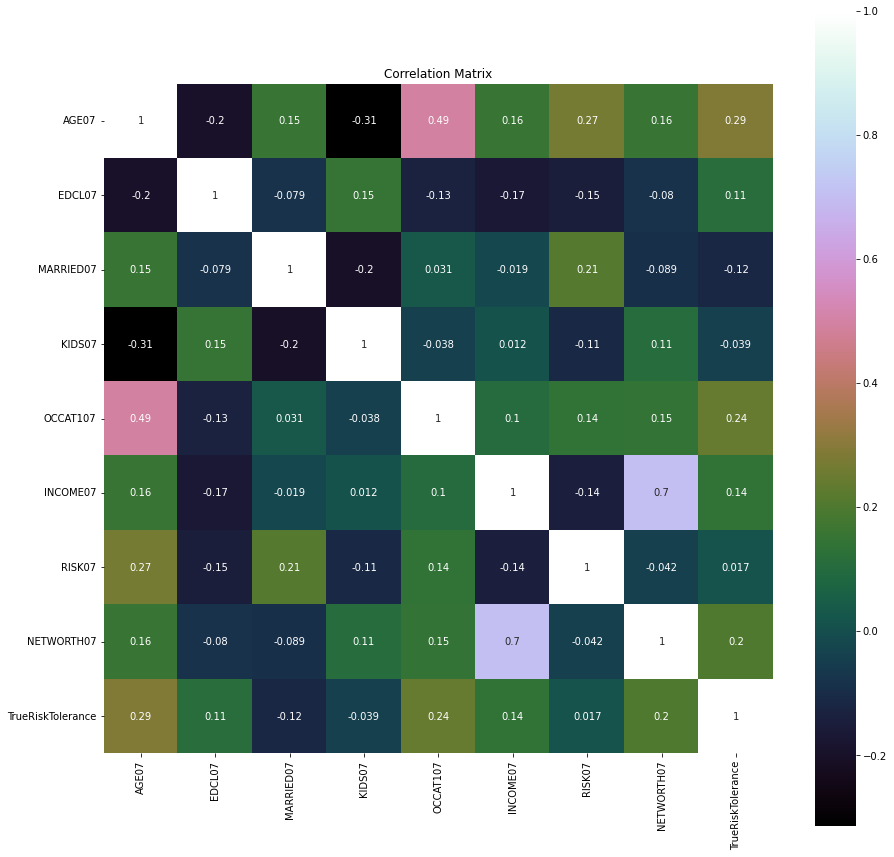

In [ ]:
# correlacion
correlation = dataset3.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

* El patrimonio neto y los ingresos estan positivamente correlacionados con la tolerancia al riesgo.
* Con un mayor numero de hijos y el matrimonio, la tolerancia al riesgo disminuye.
* A medida que disminuye la disposicion a asumir riesgos, disminuye la tolerancia al riesgo.
* Con la edad existe una relacion positiva de la tolerancia al riesgo.

<Figure size 504x504 with 0 Axes>

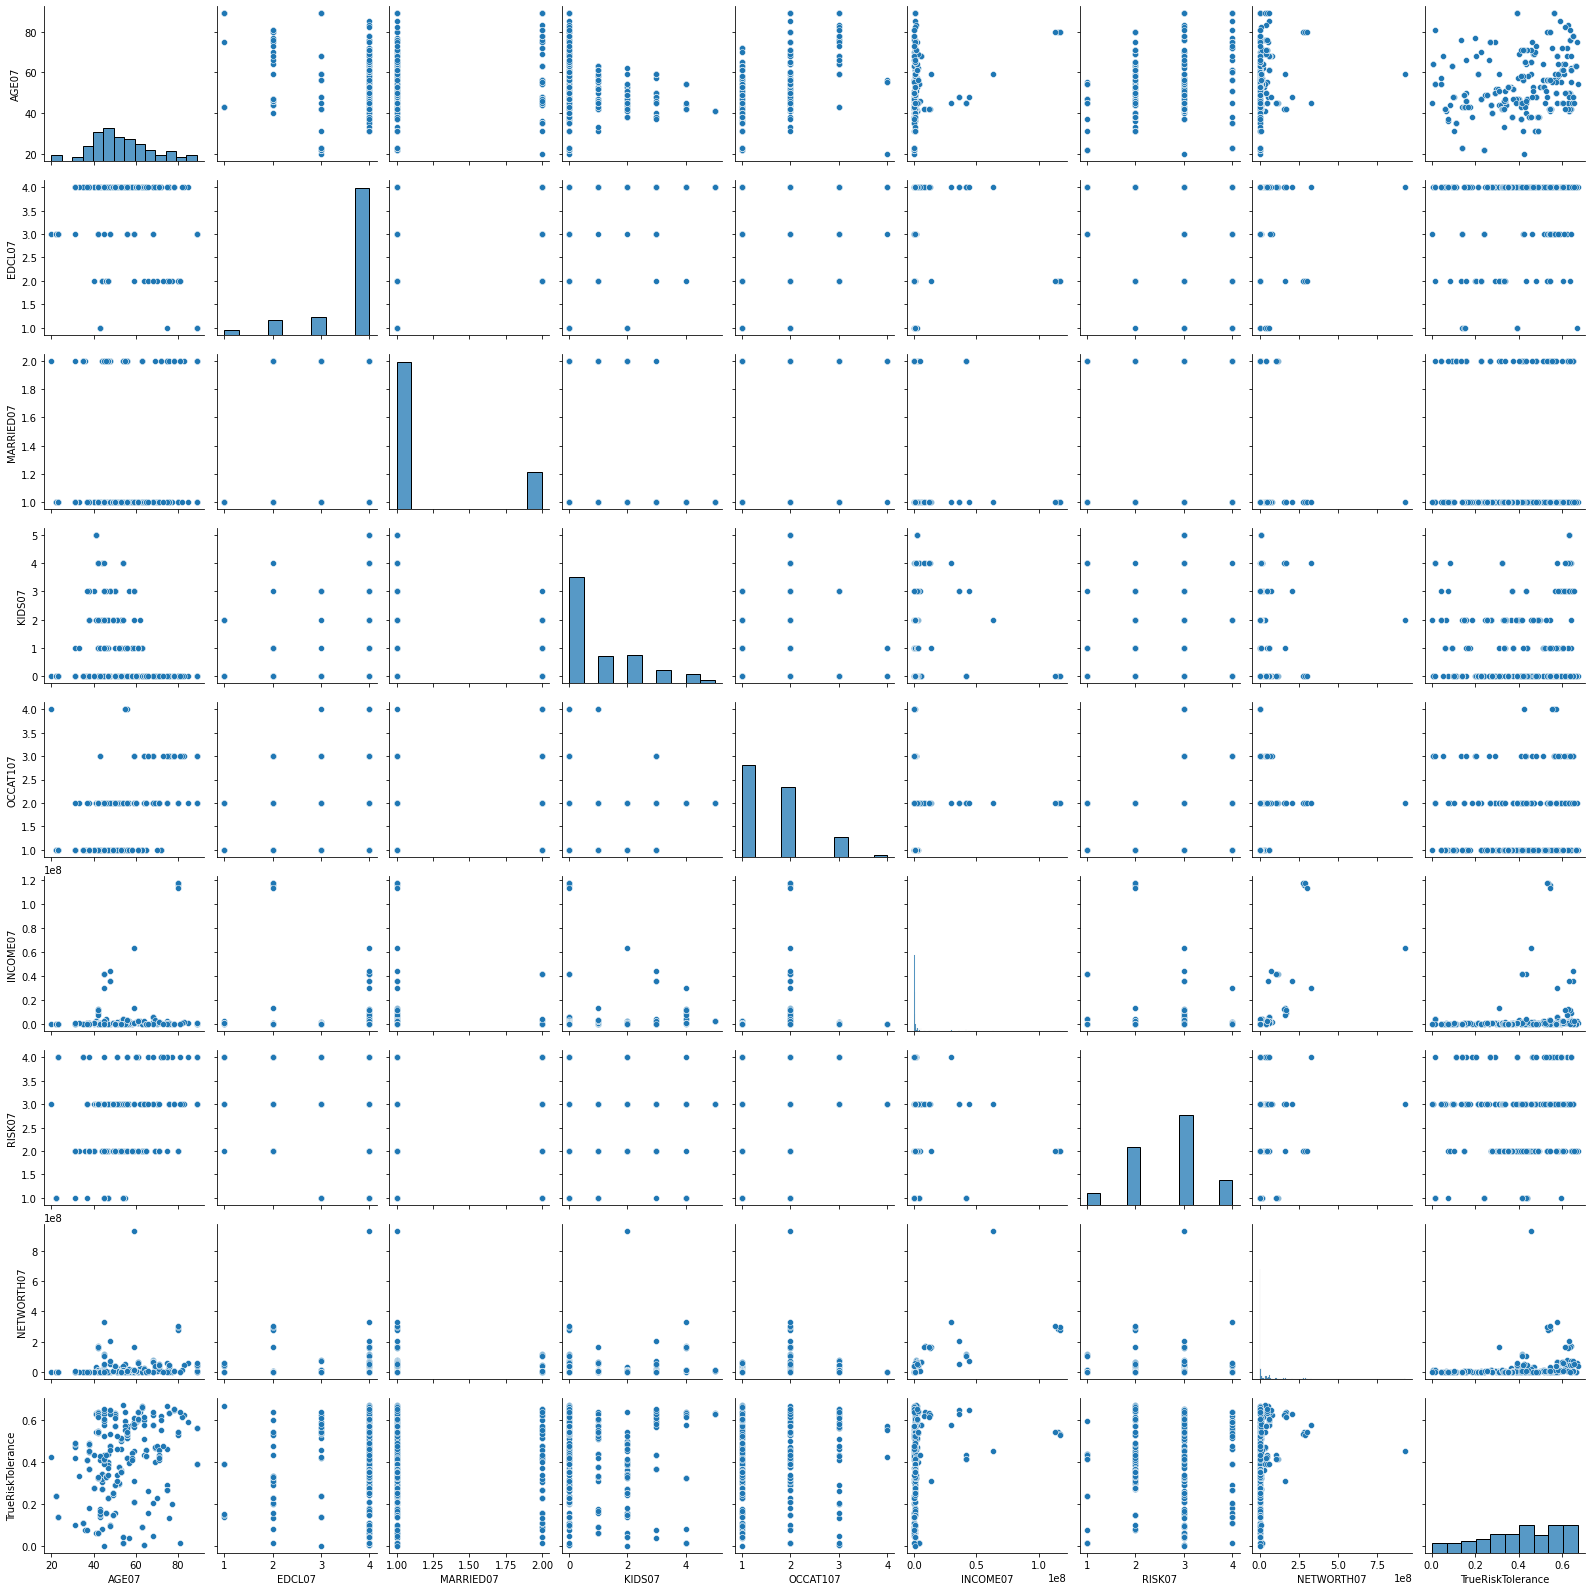

In [ ]:
plt.figure(figsize=(7,7))
sns.pairplot(dataset3)
plt.show()

* Todas las variables y su relación con la tolerancia al riesgo parecen intuitivas.

<a id='4'></a>
# 4. Evaluate Algorithms and Models

<a id='4.1'></a>
## 4.1. Train Test Split
Evaluemos los algoritmos y los modelos.

In [ ]:
# dividir el conjunto de datos de validación para el final
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

<a id='4.2'></a>
## 4.2. Test Options and Evaluation Metrics

In [ ]:
# opciones de prueba para la regresión
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

<a id='4.3'></a>
## 4.3. Compare Models and Algorithms

In [ ]:
# comprobar los algoritmos 
models = []

models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network
#models.append(('MLP', MLPRegressor()))

#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: -0.041555 (0.109033)
EN: -0.047729 (0.108990)
KNN: -0.424599 (0.141428)
CART: -0.582327 (0.243575)
SVR: -0.127821 (0.100887)
ABR: -0.376187 (0.128370)
GBR: -0.621187 (0.140844)
RFR: -0.716324 (0.107082)
ETR: -0.708728 (0.153399)


### Algorithm comparison

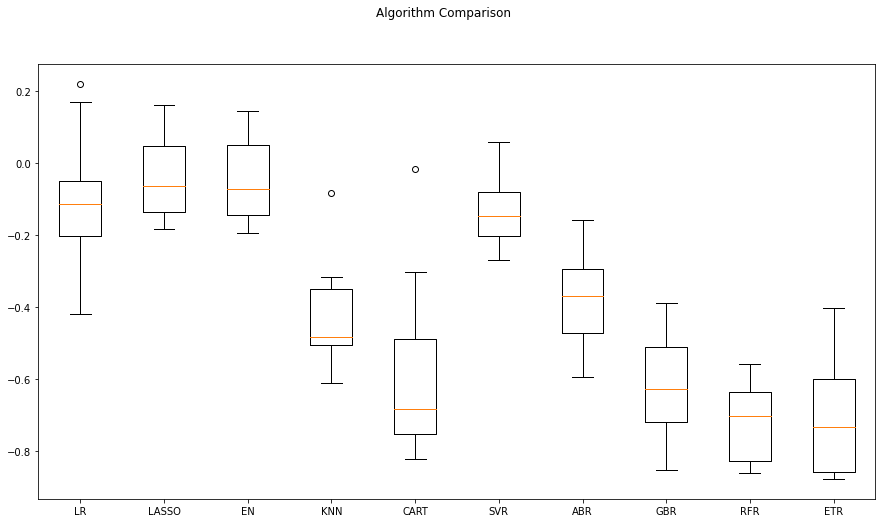

In [ ]:
# comparar algoritmos
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

* Los modelos no lineales obtienen mejores resultados que los modelos lineales, lo que significa que se utiliza una relación no lineal entre la tolerancia al riesgo y las variables de diferencia para predecirla. Dado que la regresión de bosque aleatorio es uno de los mejores métodos, lo utilizamos para seguir buscando en la red.

<a id='5'></a>
# 5. Model Tuning and Grid Search

In [ ]:
# 8. Grid search : RandomForestRegressor 
'''
n_estimators : entero, opcional (por defecto=10)
    El número de árboles en el bosque.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.712349 using {'n_estimators': 100}
0.705973 (0.108962) with: {'n_estimators': 50}
0.712349 (0.096629) with: {'n_estimators': 100}
0.711725 (0.108148) with: {'n_estimators': 150}
0.705290 (0.106737) with: {'n_estimators': 200}
0.707641 (0.108760) with: {'n_estimators': 250}
0.710719 (0.104997) with: {'n_estimators': 300}
0.708874 (0.103594) with: {'n_estimators': 350}
0.711944 (0.100753) with: {'n_estimators': 400}


* El bosque aleatorio con un número de estimadores de 100, es el mejor modelo después de la búsqueda en la cuadrícula.

<a id='6'></a>
# 6. Finalise the Model

<a id='6.1'></a>
## 6.1. Results on the Test Dataset

In [ ]:
# preparar el modelo
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.963380208622111


In [ ]:
# estimar la precisión en el conjunto de validación
# transformar el conjunto de datos de validación
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.006956953572839517
0.7867361858826243


* A partir del error cuadrático medio y el R2 mostrados anteriormente para el conjunto de pruebas, los resultados parecen buenos

<a id='6.2'></a>
## 6.2. Feature Importance and Features Intuition
Si observamos los detalles anteriores, el bosque aleatorio merece un estudio más profundo. Veamos la importancia de las características del modelo RF

[0.21489753 0.0244694  0.01370608 0.04866335 0.02505994 0.23085275
 0.05576272 0.38658822]


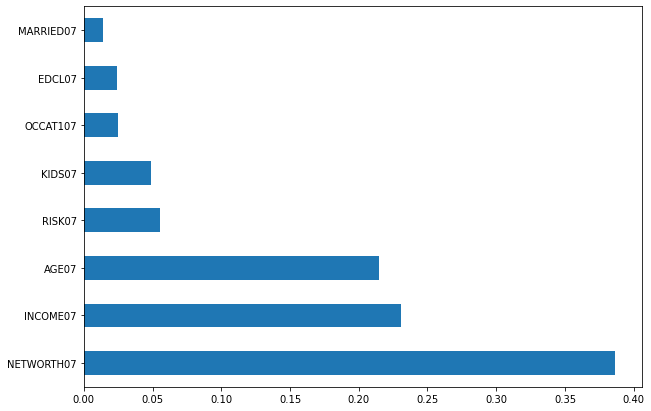

In [ ]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 100,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_) # utilizar la clase incorporada feature_importances de los clasificadores basados en árboles

# trazar un gráfico de la importancia de las características para una mejor visualización
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,7))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

* Según el gráfico anterior, los ingresos y el patrimonio neto, seguidos de la edad y la disposición a asumir riesgos, son las variables clave para decidir la tolerancia al riesgo. Estas variables han sido consideradas como las principales para modelar la tolerancia al riesgo en varias publicaciones.

<a id='6.3'></a>
## 6.3. Save Model for Later Use

In [ ]:
# Guardar el modelo usando Pickle
from pickle import dump
from pickle import load

# guardar el modelo en el disco
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [ ]:
# cargar el modelo desde el disco
loaded_model = load(open(filename, 'rb'))

# estimar la precisión en el conjunto de validación
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7575896756829157
0.007907752090201052


## **Conclusión:**

Demostramos que los modelos de aprendizaje automático podrían ser capaces de analizar objetivamente el comportamiento de los distintos inversores en un mercado cambiante y atribuir estos cambios a las variables que intervienen en la determinación del apetito por el riesgo. Con el aumento del volumen de datos de los inversores y la disponibilidad de una rica infraestructura de aprendizaje automático, estos modelos podrían resultar más útiles.

Existe una relación no lineal entre las variables y la tolerancia al riesgo. Los ingresos y el patrimonio neto, seguidos de la edad y la disposición a asumir riesgos, son las variables clave para decidir la tolerancia al riesgo. Estas variables han sido consideradas como las más importantes para modelar la tolerancia al riesgo en varias publicaciones.

# **Robo Advisor - Dashboard**

## Content
* [1. Carga de las Bibliotecas y los datos](#1)
* [2. Código para la interfaz del cuadro de mandos](#2)
* [3. Código para las funciones subyacentes dentro de la interfaz](#3)

<a id='1'></a>
## 1. Loading the Libraries and the data

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'dash', 'dash-core-components', 'dash-html-components', 'dash-daq', 'cvxopt' }
missing = required - installedPackages
if missing:
    !pip install dash==1.9.1
    !pip install dash-core-components==1.8.1
    !pip install dash-html-components==1.0.2
    !pip install dash-daq==0.4.0
    !pip install cvxopt==1.2.5

     |████████████████████████████████| 64 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 8.9 MB/s 
     |████████████████████████████████| 3.3 MB 33.2 MB/s 
     |████████████████████████████████| 187 kB 48.0 MB/s 
     |████████████████████████████████| 1.8 MB 40.9 MB/s 
     |████████████████████████████████| 357 kB 52.2 MB/s 
  Created wheel for dash: filename=dash-1.9.1-py3-none-any.whl size=71524 sha256=19ffbad4eabfafadc5e5ba5341e428f54298d5afb94ba214ade720b4cc11fa7c
  Stored in directory: /root/.cache/pip/wheels/45/9c/48/ade935f76bd79a4dcccf402cf3599a26d4e5564c71ba33efbd
  Created wheel for dash-core-components: filename=dash_core_components-1.8.1-py3-none-any.whl size=3395723 sha256=984f3b0774237eb60d475fdadf1e1db9e32a4e10b282cfb591d1b6aaabee6b6a
  Stored in directory: /root/.cache/pip/wheels/78/b8/b8/4cc057c729635376ba6b04618fca5a870671ae9bc18881231c
  Created wheel for dash-html-components: filename=dash_html_components-1.0.2-py3-none-any.whl size=427919 sha256=b

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output,State
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import dash_daq as daq
from pickle import load
import cvxopt as opt
from cvxopt import blas, solvers

### Load the data of the investors/individuals

In [ ]:
# df.head()
raw = 'https://raw.githubusercontent.com/tatsath/fin-ml/master/Chapter%205%20-%20Sup.%20Learning%20-%20Regression%20and%20Time%20Series%20models/Case%20Study%203%20-%20Investor%20Risk%20Tolerance%20and%20Robo-advisors/InputData.csv'
investors = pd.read_csv(raw, index_col = 0 )
investors.head(1)

,AGE07,EDCL07,MARRIED07,KIDS07,LIFECL07,OCCAT107,INCOME07,RISK07,WSAVED07,SPENDMOR07,NETWORTH07,TrueRiskTol
0,47,2,1,0,2,1,56443.744181,3,1,5,352641.7113,6.947439


### Load the market data and clean the data

In [ ]:
raw_sp500 = 'https://raw.githubusercontent.com/tatsath/fin-ml/master/Chapter%205%20-%20Sup.%20Learning%20-%20Regression%20and%20Time%20Series%20models/Case%20Study%203%20-%20Investor%20Risk%20Tolerance%20and%20Robo-advisors/SP500Data.csv'
assets = pd.read_csv(raw_sp500,index_col=0)
missing_fractions = assets.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

assets.drop(labels=drop_list, axis=1, inplace=True)
assets.shape
# Fill the missing values with the last value available in the dataset. 
assets=assets.fillna(method='ffill')
assets.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,AGN,ADS,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,...,UHS,UNM,VFC,VLO,VAR,VTR,VRSN,VRSK,VZ,VRTX,VIAB,V,VNO,VMC,WAB,WMT,WBA,DIS,WM,WAT,WEC,WCG,WFC,WELL,WDC,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,43.985001,67.599998,165.509995,65.559998,75.010002,131.529999,129.929993,124.050003,224.619995,79.910004,170.320007,255.330002,42.110001,101.919998,1073.209961,1065.00000,70.739998,1189.010010,11.8,58.389999,52.990002,72.410004,98.940002,59.50,141.130005,89.080002,169.910004,94.040001,72.750000,177.000000,...,115.599998,54.860001,70.075333,92.800003,110.980003,59.759998,109.470001,95.830002,53.529999,152.910004,31.190001,114.510002,77.320000,131.869995,82.930000,98.589996,74.949997,111.800003,86.099998,195.690002,65.769997,202.550003,61.090000,64.029999,81.379997,19.08,64.709999,35.299999,167.990005,31.139999,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,44.115002,69.320000,166.410004,65.940002,74.660004,131.789993,129.320007,124.949997,231.199997,80.250000,170.139999,260.070007,41.740002,101.980003,1091.520020,1082.47998,70.480003,1204.199951,11.8,58.090000,52.340000,71.800003,99.550003,60.16,141.679993,88.449997,169.070007,94.389999,73.389999,180.339996,...,113.389999,55.259998,69.472694,93.290001,111.309998,60.119999,110.900002,95.550003,52.430000,152.009995,29.950001,115.650002,77.099998,134.289993,82.260002,99.449997,75.510002,112.279999,87.349998,197.770004,65.540001,203.320007,61.560001,64.139999,82.669998,19.07,65.400002,35.610001,168.839996,32.000000,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998


In [ ]:
options=np.array(assets.columns)
# str(options)
options = []

for tic in assets.columns:
    #{'label': 'user sees', 'value': 'script sees'}
    mydict = {}
    mydict['label'] = tic #Apple Co. AAPL
    mydict['value'] = tic
    options.append(mydict)

<a id='2'></a>
## 2. Code for the dashboard Interface

In [ ]:
app = dash.Dash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

In [ ]:
app.layout = html.Div([
    html.Div([ 
        #Dashboard Name
        html.Div([
            html.H3(children='Robo Advisor Dashboard'),
            html.Div([
                html.H5(children='Step 1 : Enter Investor Characteristics '),            
                ],style={'display': 'inline-block','vertical-align': 'top',  'width': '30%',\
                         'color':'black', 'background-color': 'LightGray'}), 
            html.Div([
                html.H5(children='Step 2 : Asset Allocation and portfolio performance'),            
                ],style={'display': 'inline-block', 'vertical-align': 'top',  \
                         'color':'white','horizontalAlign' : "left", 'width': '70%', 'background-color':'black'}), 
            ],style={'font-family': 'calibri'}),        
         
         #All the Investor Characteristics
                      
       #********************Demographics Features DropDown********
         html.Div([   
          html.Div([ 
            
            html.Label('Age:',style={'padding': 5}),
            dcc.Slider(
                id='Age',
                min = investors['AGE07'].min(),
                max = 70,
                marks={ 25: '25',35: '35',45: '45',55: '55',70: '70'},              
                value=25),   
            #html.Br(),
            
            html.Label('NetWorth:', style={'padding': 5}),
            dcc.Slider(
                id='Nwcat',
                #min = investors['NETWORTH07'].min(), 
                min = -1000000, max = 3000000,
                marks={-1000000: '-$1M',0: '0',500000: '$500K',1000000: '$1M',2000000: '$2M',},                
                value=10000),
            #html.Br(),
            html.Label('Income:', style={'padding': 5}),
            dcc.Slider(
                id='Inccl',
                #min = investors['INCOME07'].min(), max = investors['INCOME07'].max(),
                min = -1000000,
                max = 3000000,
                marks={-1000000: '-$1M',0: '0',500000: '$500K',1000000: '$1M',2000000: '$2M',},
                value=100000),
            
           # html.Br(),
            html.Label('Education Level (scale of 4):', style={'padding': 5}),
            dcc.Slider(
                id='Edu',
                min = investors['EDCL07'].min(), max = investors['EDCL07'].max(),
                marks={ 1: '1',2: '2',3: '3',4: '4'},
                value=2), 
            #html.Br(),
            html.Label('Married:', style={'padding': 5}),
            dcc.Slider(
                id='Married',
                min = investors['MARRIED07'].min(), max = investors['MARRIED07'].max(),
                marks={ 1: '1',2: '2'},
                value=1), 
            #html.Br(),
            html.Label('Kids:', style={'padding': 5}),
            dcc.Slider(
                id='Kids',
                min = investors['KIDS07'].min(), max = investors['KIDS07'].max(),
                #marks={ 1: '1',2: '2',3: '3',4: '4'},
                marks=[{'label': j, 'value': j} for j in investors['KIDS07'].unique()],
                value=3), 
            #html.Br(),
            html.Label('Occupation:', style={'padding': 5}),
            dcc.Slider(
                id='Occ',
                min = investors['OCCAT107'].min(), max = investors['OCCAT107'].max(),
                marks={ 1: '1',2: '2',3: '3',4: '4'},
                value=3),            
            #html.Br(),
            html.Label('Willingness to take Risk:', style={'padding': 5}),
            dcc.Slider(
                id='Risk',
                min = investors['RISK07'].min(), max = investors['RISK07'].max(),
                marks={ 1: '1',2: '2',3: '3',4: '4'},
                value=3), 
            #html.Br(),
            html.Button(id='investor_char_button',
                            n_clicks = 0,
                            children = 'Calculate Risk Tolerance',
                            style = {'fontSize': 14, 'marginLeft': '30px', 'color' : 'white',\
                                     'horizontal-align': 'left','backgroundColor': 'grey'}),             
            #html.Br(),            
              ],style={'width': '80%'}),           
            
            ],style={'width': '30%', 'font-family': 'calibri','vertical-align': 'top','display': 'inline-block'\
                     }),
#                     , "border":".5px black solid"}),

    # ********************Risk Tolerance Charts********            
       html.Div([    
               #html.H5(children='Step 2 : Enter the Instruments for the allocation portfolio'),  
        html.Div([
            html.Div([ 
                html.Label('Risk Tolerance (scale of 100) :', style={'padding': 5}),
                dcc.Input(id= 'risk-tolerance-text'),
               
                ],style={'width': '100%','font-family': 'calibri','vertical-align': 'top','display': 'inline-block'}),

            html.Div([ 
                html.Label('Select the assets for the portfolio:', style={'padding': 5}),
                dcc.Dropdown(
                        id='ticker_symbol',
                        options = options,
                        value = ['GOOGL', 'FB', 'GS','MS','GE','MSFT'], 
                        multi = True
                        # style={'fontSize': 24, 'width': 75}
                        ),
                html.Button(id='submit-asset_alloc_button',
                            n_clicks = 0,
                            children = 'Submit',
                            style = {'fontSize': 12, 'marginLeft': '25px','color' : 'white', 'backgroundColor': 'grey'}

                ), 
               ],style={'width': '100%','font-family': 'calibri','vertical-align': 'top','display': 'inline-block'}),
            ],style={'width': '100%','display': 'inline-block','font-family': 'calibri','vertical-align': 'top'}),
           
           html.Div([                
                html.Div([
                    dcc.Graph(id='Asset-Allocation'), 
                    ], style={'width': '50%', 'vertical-align': 'top', 'display': 'inline-block', \
                      'font-family': 'calibri', 'horizontal-align': 'right'}),
                html.Div([
                    dcc.Graph(id='Performance')
                    ], style={'width': '50%', 'vertical-align': 'top', 'display': 'inline-block', \
                      'font-family': 'calibri', 'horizontal-align': 'right'}),
                   ], style={'width': '100%', 'vertical-align': 'top', 'display': 'inline-block', \
                          'font-family': 'calibri', 'horizontal-align': 'right'}),          


        ], style={'width': '70%','display': 'inline-block','font-family': 'calibri','vertical-align': 'top', 'horizontal-align': 'right'}),
       ],style={'width': '70%','display': 'inline-block','font-family': 'calibri','vertical-align': 'top'}),               

  ])    

<a id='3'></a>
## 3. Code for the underlying functions within the interface

Los pasos realizados son los siguientes: 

1) Carga del modelo de regresión para predecir la tolerancia al riesgo

2) Utilización del análisis de varianza media de Markovitz para la asignación de activos

3) Elaboración de un gráfico para la asignación de activos y el rendimiento de la cartera

#### **Click the url produced by this code to see the dashboard**

In [ ]:
def predict_riskTolerance(X_input):

    filename = 'finalized_model.sav'
    loaded_model = load(open(filename, 'rb'))
    # estimate accuracy on validation set
    predictions = loaded_model.predict(X_input)
    return predictions

#Asset allocation given the Return, variance
def get_asset_allocation(riskTolerance,stock_ticker):
    #ipdb.set_trace()
    assets_selected = assets.loc[:,stock_ticker]
    return_vec = np.array(assets_selected.pct_change().dropna(axis=0)).T
    n = len(return_vec)
    returns = np.asmatrix(return_vec)
    mus = 1-riskTolerance
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(return_vec))
    pbar = opt.matrix(np.mean(return_vec, axis=1))
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    w=portfolios['x'].T
    print (w)
    Alloc =  pd.DataFrame(data = np.array(portfolios['x']),index = assets_selected.columns)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    returns_final=(np.array(assets_selected) * np.array(w))
    returns_sum = np.sum(returns_final,axis =1)
    returns_sum_pd = pd.DataFrame(returns_sum, index = assets.index )
    returns_sum_pd = returns_sum_pd - returns_sum_pd.iloc[0,:] + 100   
    return Alloc,returns_sum_pd



#Callback for the graph
#This function takes all the inputs and computes the cluster and the risk tolerance


@app.callback(
     [Output('risk-tolerance-text', 'value')],
    [Input('investor_char_button', 'n_clicks'),
    Input('Age', 'value'),Input('Nwcat', 'value'),
    Input('Inccl', 'value'), Input('Risk', 'value'),
    Input('Edu', 'value'),Input('Married', 'value'),
    Input('Kids', 'value'),Input('Occ', 'value')])
#get the x and y axis details 

def update_risk_tolerance(n_clicks,Age,Nwcat,Inccl,Risk,Edu,Married,Kids,Occ):
      
    #ipdb.set_trace()
    
    RiskTolerance = 0
    if n_clicks != None:    
        X_input = [[Age,Edu,Married,Kids,Occ,Inccl, Risk,Nwcat]]
        RiskTolerance= predict_riskTolerance(X_input)
    #print(RiskAversion)
    #Using linear regression to get the risk tolerance within the cluster.    
    return list([round(float(RiskTolerance*100),2)])

@app.callback([Output('Asset-Allocation', 'figure'),
              Output('Performance', 'figure')],
            [Input('submit-asset_alloc_button', 'n_clicks'),
            Input('risk-tolerance-text', 'value')], 
            [State('ticker_symbol', 'value')
            ])
def update_asset_allocationChart(n_clicks, risk_tolerance, stock_ticker):
    
    Allocated, InvestmentReturn = get_asset_allocation(risk_tolerance,stock_ticker)  
    
    return [{'data' : [go.Bar(
                        x=Allocated.index,
                        y=Allocated.iloc[:,0],
                        marker=dict(color='red'),
                    ),
                    ],
            'layout': {'title':" Asset allocation - Mean-Variance Allocation"}

       },
            {'data' : [go.Scatter(
                        x=InvestmentReturn.index,
                        y=InvestmentReturn.iloc[:,0],
                        name = 'OEE (%)',
                        marker=dict(color='red'),
                    ),
                    ],
            'layout': {'title':"Portfolio value of $100 investment"}

       }]

if __name__ == '__main__':
    app.run_server()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
